# Rakan's Playground




## Setup

### Package Installing

In [1]:
!pip install spotipy

### Google Drive & Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import sys
PROJECT_ROOT = '/content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/'
sys.path.append(PROJECT_ROOT)

### Internal Imports

In [4]:
from SpotifyConnection import get_spotify_connection
import Playlist as PL
from DataProcessing import normalize_dataframe, SpotifyTracksDataset, normalize_data_by_type, normalize_data, NormalizationType

In [5]:
sp = get_spotify_connection()

### PyTorch/Numpy/Pandas

In [6]:
import numpy as np
import pandas as pd
import random

pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [115]:
def seed_torch(seed=0):
  random.seed(seed)

  np.random.seed(seed)
  np.random.RandomState(seed)

  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) #seed all gpus    
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.enabled = False  
  torch.backends.cudnn.benchmark = False

seed_torch(0)

## Loading Data

In [9]:
pl = PL.load_playlist(PROJECT_ROOT + "playlist_2sRZldX6n9oaII70OoO3zB")

Loaded playlist from file: /content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/playlist_2sRZldX6n9oaII70OoO3zB


In [10]:
pl.playlist_df.head()

,id,name,popularity,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,max_artist_popularity,avg_popularity_artist_top_tracks,release_date,explicit
0,0q75NwOoFiARAVp4EXU4Bs,Love Galore (feat. Travis Scott),76,275080,0,1,4,0.1110,0.795,0.594,0.0,0.1620,-6.200,0.0747,0.409,135.002,98,80.00,2017-06-09,True
1,593W4qZOwwdqF6YnimJjL6,Doves In The Wind (feat. Kendrick Lamar),63,266080,10,0,4,0.3430,0.692,0.713,0.0,0.1020,-4.489,0.3510,0.615,137.360,90,74.45,2017-06-09,True
2,6gU9OKjOE7ghfEd55oRO57,The Weekend,75,272186,8,0,5,0.2410,0.487,0.366,0.0,0.1260,-9.405,0.0531,0.161,68.191,83,73.00,2017-06-09,True
3,23wcL7jlwSLVZ54V1qO7oO,Plot Twist,28,227173,8,1,5,0.1270,0.590,0.652,0.0,0.0626,-5.895,0.3350,0.691,124.686,77,64.75,2017-06-30,True
4,7FYH5AW3bVfZHJIQpq3UOA,I Don't Fuck With You,75,284386,1,1,4,0.0355,0.824,0.733,0.0,0.3240,-5.475,0.0613,0.393,97.971,84,63.80,2015-02-24,True


## Cleaning Data


In [99]:
features = list(pl.playlist_df.columns)
features.remove("id")
features.remove("name")
features.remove("popularity")
# features.remove("key")
# features.remove("mode")
# features.remove("release_date")
# features.remove("explicit")
# features.remove("time_signature")
# features.remove("duration")
# features.remove("acousticness")
# features.remove("danceability")
# features.remove("energy")
# features.remove("instrumentalness")
# features.remove("liveness")
# features.remove("loudness")
# features.remove("speechiness")
# features.remove("valence")
# features.remove("tempo")
# features.remove("max_artist_popularity")
# features.remove("avg_popularity_artist_top_tracks")

print(f"Features: {features}")

regression_target = "popularity"
classification_target = "hit"
print(f"Regression Target: {regression_target}")
print(f"Classification Target: {classification_target}")

Features: ['duration', 'key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'max_artist_popularity', 'avg_popularity_artist_top_tracks', 'release_date', 'explicit']
Regression Target: popularity
Classification Target: hit


In [106]:
relevant_columns = features + [regression_target]

df = pl.get_playlist_df(relevant_columns)

df.duration = df.duration / 1000
df.duration = normalize_data_by_type(df.duration, NormalizationType.STD_CLAMP)
df.tempo = normalize_data_by_type(df.tempo,NormalizationType.DEFAULT)
df.loudness = normalize_data_by_type(df.loudness, NormalizationType.DEFAULT)
df.time_signature = normalize_data_by_type(df.time_signature, NormalizationType.DEFAULT)
df.max_artist_popularity = normalize_data(df.max_artist_popularity, data_min=0, data_max=100)
df.avg_popularity_artist_top_tracks = normalize_data(df.avg_popularity_artist_top_tracks, data_min=0, data_max=100)

df.explicit = df.explicit *1
df.release_date = 2020 - pd.to_datetime(df.release_date).dt.year


regression_df = df.copy()

classification_df = df.copy()
classification_df['hit'] = (classification_df.popularity > 50)*1
classification_df = classification_df.drop("popularity", axis=1)

print("Regression:\n")
print(f"Total Number of Tracks: {regression_df.shape[0]}")
print(regression_df.head())

print("\n")

print(f"Number of Hits: {classification_df.hit.sum()}")
print(f"Total Number of Tracks: {classification_df.shape[0]}")
print(classification_df.head())

Regression:

Total Number of Tracks: 5493
   duration  key  mode  ...  release_date  explicit  popularity
0  0.635662    0     1  ...             3         1          76
1  0.601904   10     0  ...             3         1          63
2  0.624807    8     0  ...             3         1          75
3  0.455966    8     1  ...             3         1          28
4  0.670569    1     1  ...             5         1          75

[5 rows x 18 columns]


Number of Hits: 2506
Total Number of Tracks: 5493
   duration  key  mode  ...  release_date  explicit  hit
0  0.635662    0     1  ...             3         1    1
1  0.601904   10     0  ...             3         1    1
2  0.624807    8     0  ...             3         1    1
3  0.455966    8     1  ...             3         1    0
4  0.670569    1     1  ...             5         1    1

[5 rows x 18 columns]


## Exploring Data

In [13]:
import matplotlib.pyplot as plt

In [86]:
def plot_feature_and_target(dataframe_to_plot, feature, target):
  cols = [feature, target]
  dataframe_to_plot = dataframe_to_plot[cols]

  dataframe_to_plot.plot.scatter(x=feature, y=target)
  return

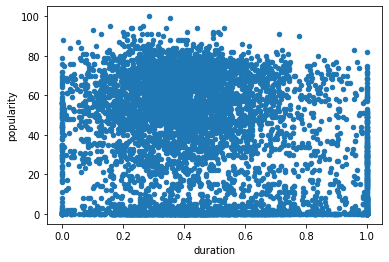

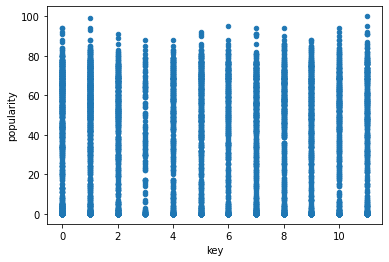

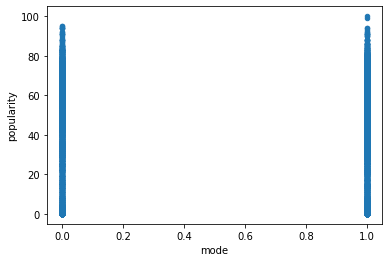

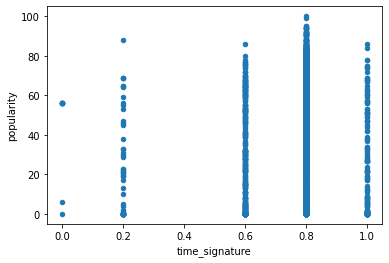

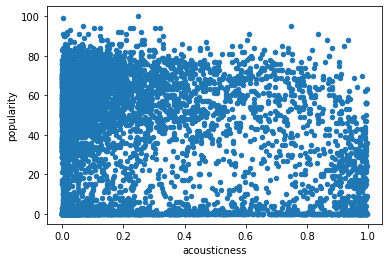

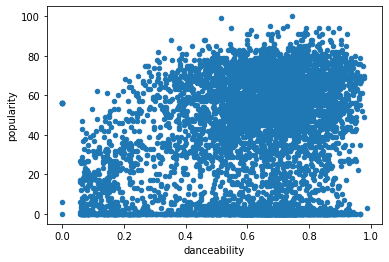

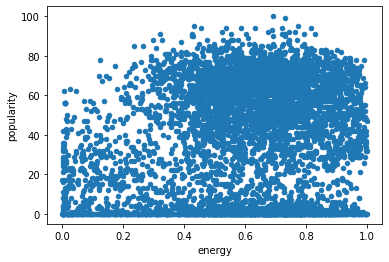

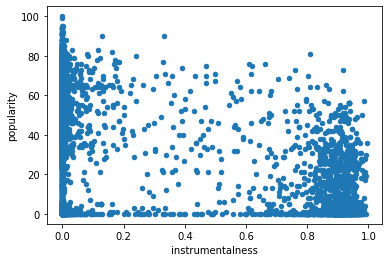

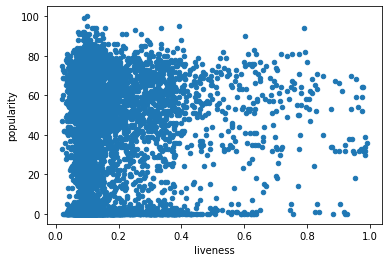

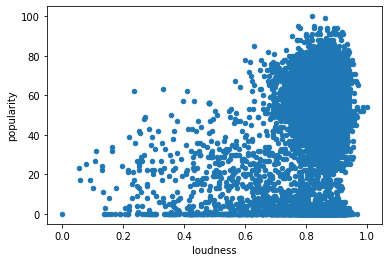

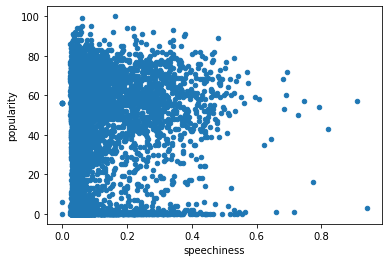

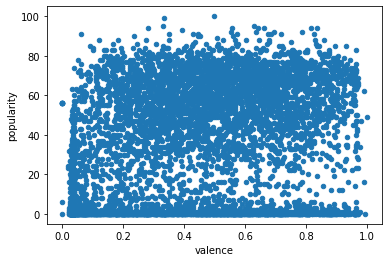

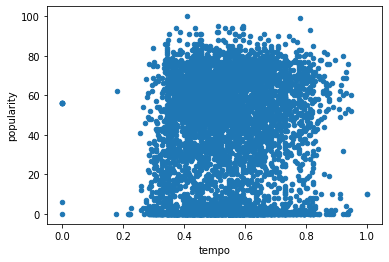

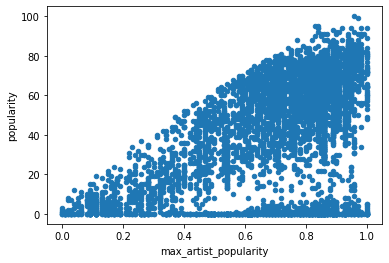

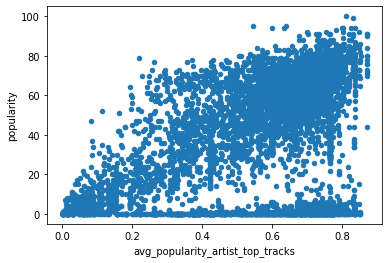

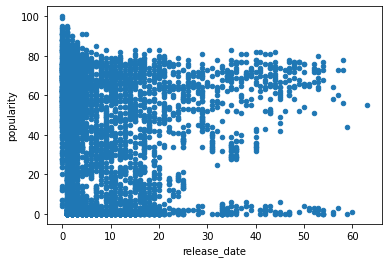

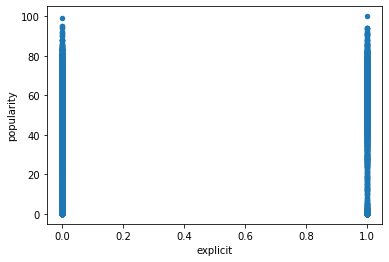

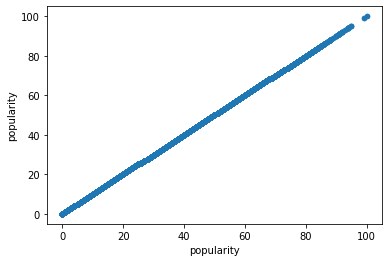

In [107]:
dataframe_to_plot = regression_df
target = regression_target
for col in dataframe_to_plot.columns:
  plot_feature_and_target(dataframe_to_plot, col, target)

## Creating Dataset

In [123]:
dataframe_to_use = classification_df
dataset_target = classification_target
seed_torch(0)
dataframe_to_use = dataframe_to_use.sample(frac=1).reset_index(drop=True)

num_data = dataframe_to_use.shape[0]

num_train = int(num_data*0.7)
num_val = int(num_data*0.15)
num_test = num_data - num_train - num_val

train_df = dataframe_to_use.iloc[0:num_train]
val_df = dataframe_to_use.iloc[num_train:num_train+num_val]
test_df = dataframe_to_use.iloc[num_train+num_val:num_data]

train = SpotifyTracksDataset(train_df, features, dataset_target)
val = SpotifyTracksDataset(val_df, features, dataset_target)
test = SpotifyTracksDataset(test_df, features, dataset_target)

In [77]:
plot_feature_and_target(train_df, 'artist_popularity', 'hit')
plot_feature_and_target(val_df, 'artist_popularity', 'hit')
plot_feature_and_target(test_df, 'artist_popularity', 'hit')

KeyError: ignored

In [109]:
train_df.head()

,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,max_artist_popularity,avg_popularity_artist_top_tracks,release_date,explicit,hit
0,0.370943,8,0,0.8,0.3100,0.468,0.630,0.000000,0.137,0.851313,0.0843,0.7620,0.417669,0.94,0.749,1,0,1
1,0.619856,9,1,0.8,0.0193,0.659,0.841,0.000110,0.298,0.874776,0.0283,0.4160,0.462580,0.75,0.664,17,1,0
2,0.610854,0,1,0.8,0.0168,0.518,0.587,0.000001,0.206,0.820273,0.1200,0.6310,0.449413,0.77,0.634,2,0,0
3,0.651765,1,1,0.8,0.6000,0.497,0.263,0.912000,0.108,0.660308,0.0367,0.0678,0.548161,0.27,0.183,7,0,0
4,0.458096,10,1,0.8,0.0162,0.719,0.798,0.000002,0.134,0.894605,0.0361,0.5910,0.548298,0.88,0.715,10,0,1


## Model

### Regression

In [16]:
class RegressionNet(nn.Module):
  def __init__(self):
    super(TestNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,1)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

### Classification

In [110]:
class ClassificationNet(nn.Module):
  def __init__(self):
    super(ClassificationNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 50),
        nn.Tanh(),
        nn.Linear(50,50),
        nn.Tanh(),
        nn.Linear(50,2)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

## Training

### Helper Functions

In [19]:
def get_error_regression(model, data):
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()
  
  error_rate = total_error/len(data)
  return error_rate

In [20]:
def get_error_classification(model, data):
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()
  
  error_rate = 1 - (total_error/len(data))
  return error_rate

def get_stats_classification(model, data, criterion, bs=100):
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0
  total_loss = 0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error_rate = 1 - (total_error/len(data))
  return error_rate, avg_loss

In [21]:
def predict_some(model, data, num_to_predict):
  for i in range(0, num_to_predict):
    features, target = data[i]
    features = features.to(device)
    target = target.to(device)

    out = model(features.unsqueeze(0)).clamp(min=0,max=100)
    print(f"Actual: {round(target.item(), 2)};  Predicted: {round(out.item(), 2)}")

In [22]:
import matplotlib.pyplot as plt

def subsample_series(series, subsampling=1):
  '''
  Subsamples data series
  '''
  indices = np.arange(0,len(series),subsampling)
  subsampled_series = series[indices]
  return indices + 1, subsampled_series

def plot_data(data, multiple_series=False, subsampling=1, labels=None, title="", xlabel="", ylabel=""):
    plt.title(title)
    
    n = len(data)

    if multiple_series:
      for i, series in enumerate(data, 0):
        indices, subsampled_series = subsample_series(np.array(series), subsampling=subsampling)
        if labels:
          plt.plot(indices, subsampled_series, label=labels[i])
        else:
          plt.plot(indices, subsampled_series,)
    else:
      indices, subsampled_series = subsample_series(np.array(data), subsampling=subsampling)
      if labels:
          plt.plot( indices, subsampled_series, label=labels)
      else:
        plt.plot( indices, subsampled_series)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if labels:
      plt.legend(loc='best')

    plt.show()

### Train Function

#### Regression

In [22]:
def train_net_regression(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  for epoch in range(1, epochs + 1):
    epoch_error = 0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)
      
      optimizer.zero_grad()
      out = model(features)
      
      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()


      epoch_loss += loss.item()
      epoch_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = epoch_error / len(train_data)
    val_error_rate = get_error(model, valid_data)
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")

    print()
    predict_some(model, train_data, 2)
    predict_some(model, valid_data, 2)

    print("\n")

#### Classification

In [60]:
def train_net_classification(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []

  for epoch in range(1, epochs + 1):
    epoch_error = 0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)

      targets = targets.squeeze(1).long()
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      out = torch.softmax(out, dim=1)

      epoch_loss += loss.item()
      epoch_error += out.argmax(dim=1).eq(targets).sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = 1 - (epoch_error / len(train_data))
    val_error_rate, val_loss = get_stats_classification(model, valid_data, criterion, bs=bs)
    
    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print("\n")

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Accuracy by Epoch", xlabel='Epoch', ylabel='Error Rate')

### Training Model

#### Attempt 1

Streaming output truncated to the last 5000 lines.

Epoch 4287
  Train Error: 0.0045539780337530145
  Valid Error: 0.515
  Train Loss: 0.008435272029601038
  Valid Loss: 0.8211133182048798


Epoch 4288
  Train Error: 0.00428609697294402
  Valid Error: 0.5137499999999999
  Train Loss: 0.008362444583326578
  Valid Loss: 0.8185049593448639


Epoch 4289
  Train Error: 0.00428609697294402
  Valid Error: 0.5137499999999999
  Train Loss: 0.009224311623256654
  Valid Loss: 0.8200355470180511


Epoch 4290
  Train Error: 0.00428609697294402
  Valid Error: 0.5175000000000001
  Train Loss: 0.01020902069285512
  Valid Loss: 0.8246901035308838


Epoch 4291
  Train Error: 0.005089740155371003
  Valid Error: 0.51625
  Train Loss: 0.013598526187706739
  Valid Loss: 0.819990485906601


Epoch 4292
  Train Error: 0.004018215912135026
  Valid Error: 0.515
  Train Loss: 0.012018783192615956
  Valid Loss: 0.8190324604511261


Epoch 4293
  Train Error: 0.003482453790517037
  Valid Error: 0.52
  Train Loss: 0.

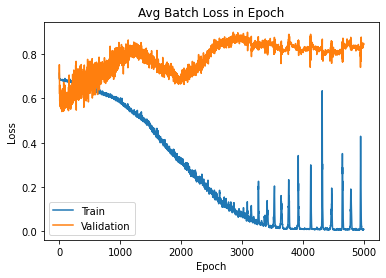

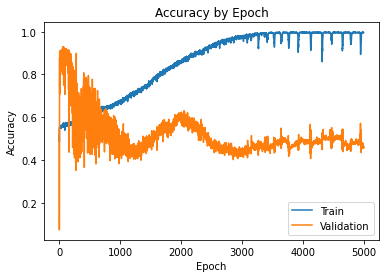

In [ ]:
model = ClassificationNet()

if torch.cuda.is_available():
  model.cuda()

train_net_classification(model, train, val, bs=512, lr=0.01, epochs=5000)

#### Attempt 2

Streaming output truncated to the last 5000 lines.

Epoch 287
  Train Error: 0.23172951885565674
  Valid Error: 0.2636695018226003
  Train Loss: 0.44233951119125864
  Valid Loss: 0.5637764242979196


Epoch 288
  Train Error: 0.22912873862158645
  Valid Error: 0.26488456865127585
  Train Loss: 0.4360975232280669
  Valid Loss: 0.5646569820550772


Epoch 289
  Train Error: 0.22782834850455136
  Valid Error: 0.26852976913730253
  Train Loss: 0.4361873615960606
  Valid Loss: 0.5661137195733877


Epoch 290
  Train Error: 0.23094928478543564
  Valid Error: 0.267314702308627
  Train Loss: 0.4399533989976664
  Valid Loss: 0.5649607319098252


Epoch 291
  Train Error: 0.22678803641092327
  Valid Error: 0.2636695018226003
  Train Loss: 0.4381612216840025
  Valid Loss: 0.5637026337476877


Epoch 292
  Train Error: 0.22678803641092327
  Valid Error: 0.2660996354799514
  Train Loss: 0.44037771469256914
  Valid Loss: 0.5658453106880188


Epoch 293
  Train Error: 0.22938881664499344
  Valid Error: 0.2

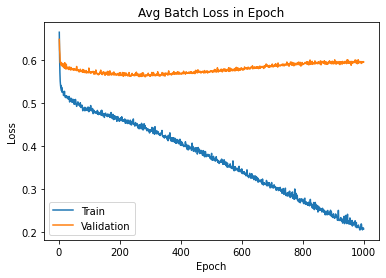

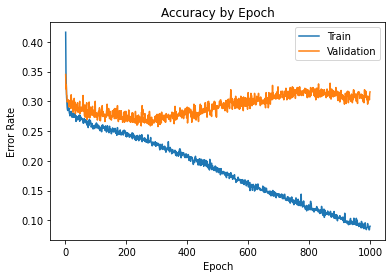

In [127]:
model = ClassificationNet()

if torch.cuda.is_available():
  model.cuda()

train_net_classification(model, train, val, bs=64, lr=0.001, epochs=1000)

## Evaluation

In [126]:
error = get_error_classification(model, test)
print(error)

0.26909090909090905


In [57]:
def get_baseline_regression_error(df):
  total_error = 0
  errors = (df.artist_popularity * 100 - df.popularity).abs()
  total_error = errors.sum()
  error_rate = total_error/df.shape[0]
  return error_rate

def get_baseline_classification_error(df):
  total_error = 0
  correct = (df.hit == (df.avg_popularity_artist_top_tracks*100 > 50)).sum()
  error_rate = 1 - (correct/df.shape[0])
  return error_rate

In [124]:
baseline_error = get_baseline_classification_error(train_df)
print(baseline_error)
baseline_error = get_baseline_classification_error(val_df)
print(baseline_error)
baseline_error = get_baseline_classification_error(test_df)
print(baseline_error)

0.29986996098829644
0.31834750911300125
0.3103030303030303


In [41]:
val_df.head()
correct = (val_df.hit == (val_df.max_artist_popularity*100 > 50)).sum()
print(correct)
print(val_df.shape)

677
(823, 14)
